In [1]:
# import library
import numpy as np 
import pandas as pd
import re
import os

import matplotlib.pyplot as plt
%matplotlib inline

import keras
import keras.utils
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten

from functools import partial
from keras import metrics

In [2]:
MAX_SEQUENCES_LENGTH = 50 # Maximum kata pada kalimat
MAX_NB_WORDS = 6000 # Vocabulary size
EMBEDDING_DIM = 50 # Dimensions of Glove word vector kadang bisa juga 100

In [3]:
# open dataset,save on dataframe
df = pd.read_csv("just_stemming.csv",encoding="ISO-8859-1")

# membuka data slang (data yang akan dibenarkan)
with open('slang.txt') as file:
    slang_map = dict(map(str.strip, line.partition('\t')[::2])
    for line in file if line.strip())
    
df.head()

,text,label
0,konflik rebut tanah,0
1,palestina taat kaffah islam ganti demokrasi si...,0
2,palestina rohingya konflik politik sih oknum l...,1
3,teroris islam gejala imbas konflik israel pale...,1
4,gregetan turun moderat peduli zionisme gera du...,2


1    686
0    370
2    346
Name: label, dtype: int64


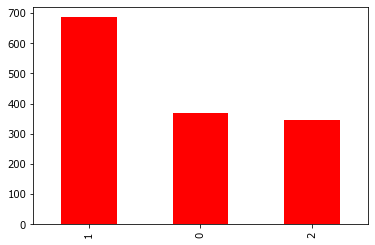

In [4]:
# menghitung Label sentimen (menampilkan tabel pembagian label sentimen)
labels = df.label
labels_count = labels.value_counts()
labels_count.plot(kind="bar", x='Label', y='Jumlah', color='red')
print(labels.value_counts())

In [5]:
# Prepare to X as Feature
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
sequences = tokenizer.texts_to_sequences(df.text)
# Banyak kata yang telah di tokenizer
word_index = tokenizer.word_index

In [6]:
print('Found %d unique words.' % len(word_index))

Found 2608 unique words.


In [7]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCES_LENGTH, padding='post')

In [8]:
# Prepare to y as label
y = df["label"]
y = to_categorical(y)

In [9]:
classes = ['0', '1', '2']

In [10]:
# Menyimpan dataset yg sudah di split agar bisa di panggil kembali
#import pickle
#with open('split_dataset/datset70.pickle', 'wb') as f:
#pickle.dump([X_train, X_test, y_train, y_test], f)

In [11]:
# open Glove
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join('dataset/glove/vectors.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 331286 word vectors.


In [12]:
# Use GloVe as Word Embedding
hits = 0
misses = 0
index = []
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        index.append(word)

In [13]:
# test = embeddings_index.get("netizen")
# test

In [14]:
# jumlah kata yg berhasil di embedding
#hits

In [15]:
# jumlah kata yg miss tidak ada dalam vector glove
#misses

In [16]:
# kata-kataa yang tidak berhasil di bobot
#index

In [17]:
# Embedding layer with glove
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCES_LENGTH,weights=[embedding_matrix],trainable=True)

In [ ]:
# model 1
# Create Model CNN
# def create_model():
#     model = Sequential()
#     model.add(embedding_layer)
#     model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
#     model.add(Dropout(0.3))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.2))
#     model.add(Flatten())
# #     model.add(Dense(16,activation="relu"))
# #     model.add(Dropout(0.3))
#     model.add(Dense(3, activation='softmax'))
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     model.summary()
#     return model

In [ ]:
# from keras.layers import GlobalMaxPooling1D

In [18]:
# Create Model CNN
# model 2
def create_model():
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
#     model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.3))
    model.add(GlobalMaxPooling1D())
#     model.add(Flatten())
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [19]:
# Train Model
cnn_model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            130450    
                                                                 
 conv1d (Conv1D)             (None, 50, 128)           19328     
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 128)          0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 25, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 64)            24640     
                                                        

In [20]:
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify=y)

In [21]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
31/31 [==============================] - 3s 41ms/step - loss: 1.1707 - accuracy: 0.4098 - val_loss: 1.0501 - val_accuracy: 0.4893
Epoch 2/10
31/31 [==============================] - 1s 26ms/step - loss: 1.0394 - accuracy: 0.4883 - val_loss: 1.0369 - val_accuracy: 0.4846
Epoch 3/10
31/31 [==============================] - 1s 23ms/step - loss: 1.0441 - accuracy: 0.4811 - val_loss: 1.0310 - val_accuracy: 0.5036
Epoch 4/10
31/31 [==============================] - 1s 23ms/step - loss: 1.0191 - accuracy: 0.5005 - val_loss: 1.0273 - val_accuracy: 0.5107
Epoch 5/10
31/31 [==============================] - 1s 25ms/step - loss: 1.0045 - accuracy: 0.5127 - val_loss: 1.0178 - val_accuracy: 0.5202
Epoch 6/10
31/31 [==============================] - 1s 25ms/step - loss: 1.0085 - accuracy: 0.5158 - val_loss: 1.0195 - val_accuracy: 0.5368
Epoch 7/10
31/31 [==============================] - 1s 25ms/step - loss: 0.9679 - accuracy: 0.5372 - val_loss: 0.9860 - val_accuracy: 0.5653
Epoch 8/10
31

CNN Accuracy: 0.5771971496437055


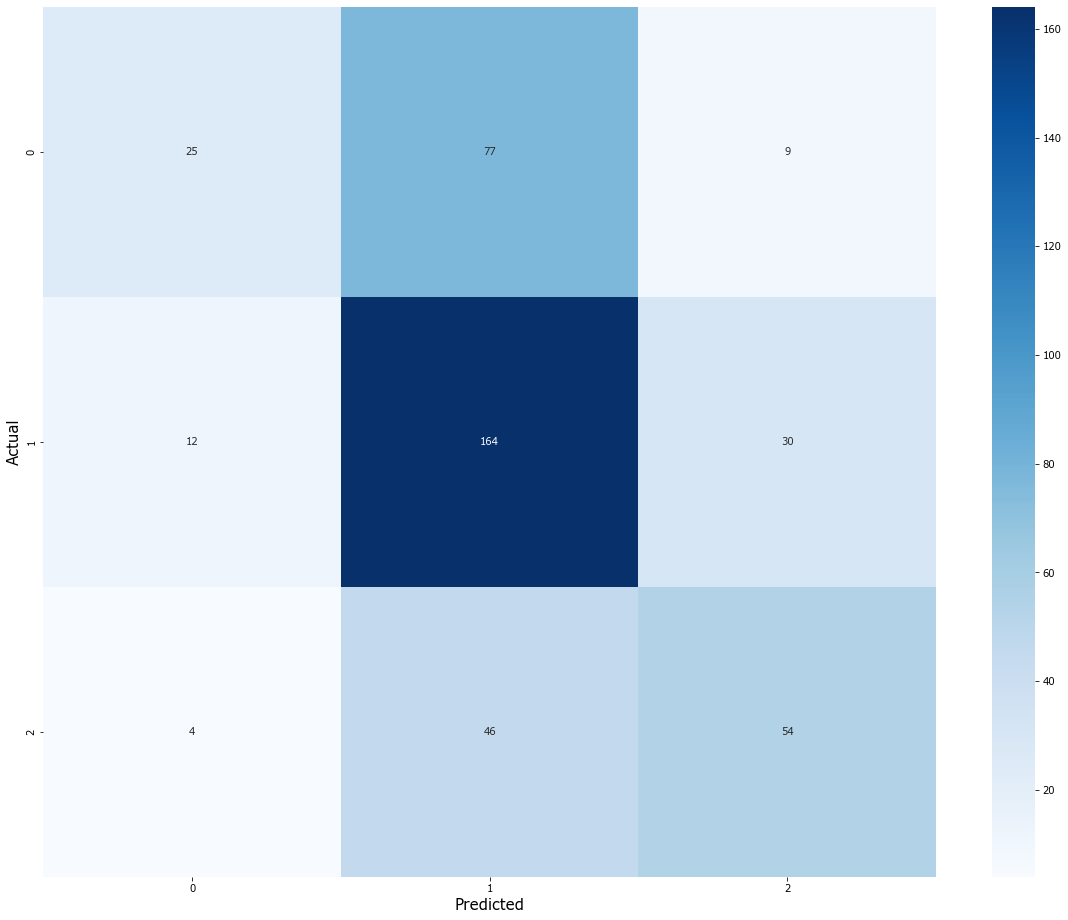

In [22]:
# confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
ypred = cnn_model.predict(X_test)
cnn_accuracy = accuracy_score(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
print("CNN Accuracy:",cnn_accuracy)
cnn_cn = confusion_matrix(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
plt.subplots(figsize=(20,16))
sns.heatmap(cnn_cn,annot=True,fmt="1d",cmap="Blues",cbar=True,xticklabels=classes,yticklabels=classes)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
# plt.savefig('model60_e40.png')
plt.show()

In [23]:
cnn_cn

array([[ 25,  77,   9],
       [ 12, 164,  30],
       [  4,  46,  54]], dtype=int64)

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=-1), ypred.argmax(axis=-1),target_names= classes))

              precision    recall  f1-score   support

           0       0.61      0.23      0.33       111
           1       0.57      0.80      0.67       206
           2       0.58      0.52      0.55       104

    accuracy                           0.58       421
   macro avg       0.59      0.51      0.51       421
weighted avg       0.58      0.58      0.55       421



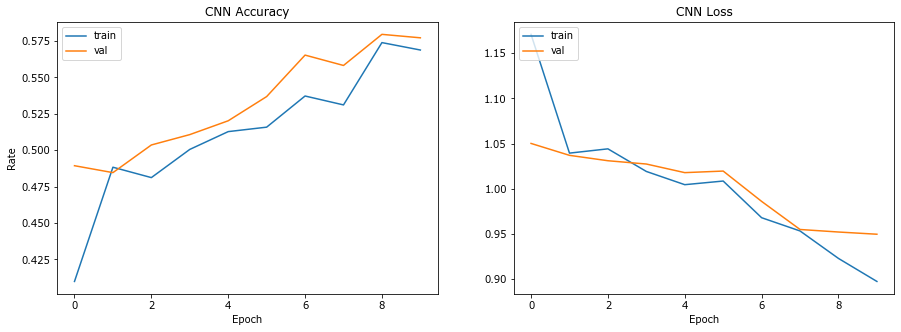

In [25]:
fig3, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axe1[0].plot(cnn_history.history["accuracy"],label="accuracy")
axe1[0].plot(cnn_history.history["val_accuracy"],label="accuracy")
axe1[0].legend(['train', 'val'], loc='upper left')
axe1[1].plot(cnn_history.history["loss"],label="loss")
axe1[1].plot(cnn_history.history["val_loss"],label="loss")
axe1[1].legend(['train', 'val'], loc='upper left')
axe1[0].title.set_text("CNN Accuracy")
axe1[1].title.set_text("CNN Loss")
axe1[0].set_xlabel("Epoch")
axe1[1].set_xlabel("Epoch")
axe1[0].set_ylabel("Rate")
plt.show()

In [26]:
cnn_history1 = cnn_model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
31/31 [==============================] - 1s 27ms/step - loss: 0.8733 - accuracy: 0.5994 - val_loss: 0.9290 - val_accuracy: 0.5914
Epoch 2/40
31/31 [==============================] - 1s 26ms/step - loss: 0.8480 - accuracy: 0.6096 - val_loss: 0.9231 - val_accuracy: 0.5843
Epoch 3/40
31/31 [==============================] - 1s 24ms/step - loss: 0.8310 - accuracy: 0.6157 - val_loss: 0.9167 - val_accuracy: 0.6033
Epoch 4/40
31/31 [==============================] - 1s 23ms/step - loss: 0.7792 - accuracy: 0.6504 - val_loss: 0.9038 - val_accuracy: 0.5796
Epoch 5/40
31/31 [==============================] - 1s 24ms/step - loss: 0.7010 - accuracy: 0.6932 - val_loss: 0.8805 - val_accuracy: 0.6010
Epoch 6/40
31/31 [==============================] - 1s 24ms/step - loss: 0.6756 - accuracy: 0.7013 - val_loss: 0.8830 - val_accuracy: 0.6010
Epoch 7/40
31/31 [==============================] - 1s 23ms/step - loss: 0.6257 - accuracy: 0.7329 - val_loss: 0.9147 - val_accuracy: 0.5748
Epoch 8/40
31

In [ ]:
# word cloud